In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Activation

import datetime

# pandas : csv 파일 로드
# numpy : 행렬 연산
# matplotlib.pyplot : 데이터 시각화
# keras : 딥러닝 모델 작성

In [15]:
# Load Dataset

data = pd.read_csv('BTC-USD.csv') # pd.read_csv() : csv 파일 로드
data.head() # df.head() : 데이터프레임의 맨 앞 5줄 데이터 출력

,Date,Open,High,Low,Close,Adj Close,Volume
361,2023-03-23,27301.957031,28729.843750,27183.363281,28333.972656,28333.972656,24220433689
362,2023-03-24,28324.111328,28388.437500,27039.265625,27493.285156,27493.285156,25980310960
363,2023-03-25,27487.337891,27791.826172,27196.234375,27494.707031,27494.707031,13383005987
364,2023-03-26,27495.523438,28178.144531,27445.046875,27994.330078,27994.330078,13878363192
365,2023-03-27,28001.037109,28028.726563,27694.707031,27746.880859,27746.880859,14246617088


In [16]:
# Compute Middle Price
high_prices = data['High'].values
low_prices = data['Low'].values
mid_prices = (high_prices + low_prices)/2

In [17]:
# Create Windows
seq_len = 50        # seq_len : window size(최근 데이터(50일)를 가지고 다음 데이터를 예측)
sequence_length = seq_len + 1

result = []
for index in range(len(mid_prices) - sequence_length):
    result.append(mid_prices[index: index + sequence_length])

In [18]:
# Normalize Data
normalized_data = []
for window in result:
    normalized_window = [((float(p)/float(window[0]))-1) for p in window] # window의 0번째 인덱스를 기준으로 정규화(normalization)
    normalized_data.append(normalized_window)
    
result = np.array(normalized_data)

# split train and test data
row = int(round(result.shape[0]*0.9)) # 전체 데이터의 90% 를 training set으로 지정
train = result[:row, :]
np.random.shuffle(train) # np.random.shuffle() : 배열의 값을 랜덤으로 섞는다.

x_train = train[:, :-1] # x_train 에 50 개의 데이터를 넣고(학습)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1],1))
y_train = train[:, -1] # y_train 에 다음데이터 1개 넣음(학습)

x_test = result[row:, :-1] # x_test 에 50개의 데이터 넣고(테스트)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1],1))
y_test = result[row:, -1] # y_test 에 다음데이터 1개 넣음(테스트)

x_train.shape, x_test.shape

((284, 50, 1), (31, 50, 1))

In [19]:
# Build a Model
model = Sequential() # keras.models.Sequential() : 모델을 순차적으로 정의하는 클래스

model.add(LSTM(50, return_sequences=True, input_shape=(50,1))) # keras. layers.LSTM() : LSTM 레이어  # model.add() : 모델에 레이어를 추가한다. 

model.add(LSTM(64, return_sequences=False))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='rmsprop') # mse : Mean Squared Error

model.summary() # model.summary() : 모델의 개요를 출력한다.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50, 50)            10400     
                                                                 
 lstm_3 (LSTM)               (None, 64)                29440     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Training
model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          batch_size=10,
          epochs=20) # model.fit() : 모델을 학습시킨다.
                     # batch_size : 한번에 묶어서 학습시킬 개수 
                     # epochs : 총 횟수 20 번 

Epoch 1/20
29/29 [==============================] - 14s 185ms/step - loss: 0.0102 - val_loss: 0.0098
Epoch 2/20
29/29 [==============================] - 2s 75ms/step - loss: 0.0050 - val_loss: 0.0145
Epoch 3/20
29/29 [==============================] - 2s 83ms/step - loss: 0.0041 - val_loss: 0.0079
Epoch 4/20
29/29 [==============================] - 2s 63ms/step - loss: 0.0036 - val_loss: 0.0076
Epoch 5/20
29/29 [==============================] - 3s 87ms/step - loss: 0.0032 - val_loss: 0.0078
Epoch 6/20
29/29 [==============================] - 2s 81ms/step - loss: 0.0028 - val_loss: 0.0055
Epoch 7/20
29/29 [==============================] - 2s 85ms/step - loss: 0.0027 - val_loss: 0.0054
Epoch 8/20
29/29 [==============================] - 2s 78ms/step - loss: 0.0025 - val_loss: 0.0089
Epoch 9/20
29/29 [==============================] - 2s 86ms/step - loss: 0.0025 - val_loss: 0.0041
Epoch 10/20
29/29 [==============================] - 2s 75ms/step - loss: 0.0024 - val_loss: 0.0043
Epoch 1

1/1 [==============================] - 0s 113ms/step


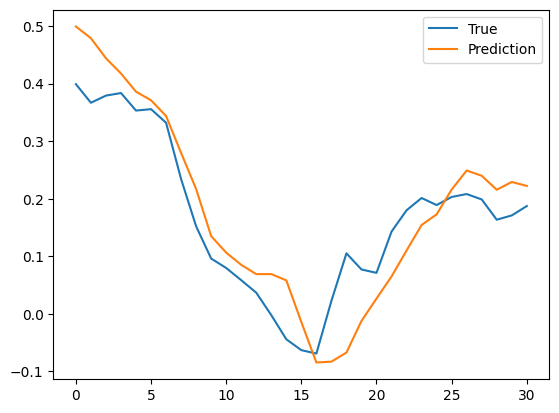

In [23]:
# Prediction
pred = model.predict(x_test) # model.predict() : 모델을 사용하여 예측한다.

fig = plt.figure(facecolor='white')
ax = fig.add_subplot(111)
ax.plot(y_test, label='True')
ax.plot(pred, label='Prediction')
ax.legend()
plt.show()